In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..', 'bball_code'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('/Users/drewadamski/Desktop/capstone-one-master/Update/Data')

In [2]:
%matplotlib inline
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statsmodels.stats import weightstats

# Set graph style to Seaborn's default
sns.set()

In [3]:
df = pd.read_csv(sys.path[-1]+'/cleaned_data.csv', index_col=0)

In [4]:
df.shape

(9273, 75)

# Outlier Removal
I want to look at distributions and potentially remove outliers. Outliers are super important because when it comes to stats like per 100 possessions, there is a high likelihood of bench players having incredibly juiced stats. To manage this, I am dropping all players with fewer than 500 total minutes played in a season.

In [5]:
test_df_2019 = df[df.season == 2019]
test_df_rest = df[df.season != 2019]

In [6]:
outlier_free_df = test_df_rest[test_df_rest.mp_tot > 500].copy()
outlier_2 = test_df_2019[test_df_2019.mp_tot > 396]

In [10]:
outlier_free_df = pd.concat([outlier_free_df, outlier_2])

In [11]:
outlier_free_df.reset_index(drop=True, inplace=True)

In [12]:
df.shape[0], outlier_free_df.shape[0]

(9273, 6693)

In [13]:
outlier_free_df.head()

,season,age,tm,lg,pos,g,gs,mp_pg,fg_pg,fga_pg,...,tov_pct,usg_pct,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
0,2000,24.0,LAC,NBA,PF,39.0,23.0,15.0,1.6,4.1,...,14.6,17.3,-0.3,0.6,0.3,0.028,-3.3,-1.0,-4.2,-0.3
1,2001,25.0,CLE,NBA,PF,65.0,8.0,17.0,1.4,2.5,...,17.6,9.9,1.0,1.0,1.9,0.084,-2.4,-0.1,-2.4,-0.1
2,2002,26.0,PHI,NBA,PF,77.0,9.0,17.9,2.4,4.3,...,13.4,15.1,2.2,2.0,4.1,0.144,-0.7,0.1,-0.6,0.5
3,2003,27.0,MIL,NBA,C,56.0,54.0,28.2,4.6,9.2,...,12.0,18.7,1.2,1.6,2.7,0.083,-1.1,-0.7,-1.8,0.1
4,2004,28.0,TOT,NBA,PF-C,49.0,23.0,19.2,2.1,4.2,...,14.5,13.0,0.6,1.3,1.9,0.096,-1.6,0.4,-1.2,0.2


In [14]:
outlier_free_df.describe()

,season,age,g,gs,mp_pg,fg_pg,fga_pg,fg_pct,three_pg,three_att_pg,...,tov_pct,usg_pct,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
count,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,...,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000
mean,2009.678918,26.789631,65.615867,35.147169,24.577155,3.818811,8.426774,0.452457,0.743971,2.084177,...,13.330719,19.129703,1.911071,1.682429,3.593441,0.095035,-0.448439,-0.008232,-0.456835,0.906365
std,5.743665,4.232446,14.106309,28.939871,7.924654,2.051036,4.373607,0.057788,0.738784,1.936990,...,3.805959,5.001873,2.215310,1.166251,2.992545,0.054610,2.362167,1.134244,2.665522,1.495899
min,2000.000000,19.000000,14.000000,0.000000,7.000000,0.400000,1.000000,0.282000,0.000000,0.000000,...,2.200000,5.100000,-3.300000,-0.600000,-2.100000,-0.091000,-7.300000,-3.900000,-8.700000,-2.000000
25%,2005.000000,24.000000,56.000000,7.000000,18.000000,2.200000,5.000000,0.414000,0.000000,0.200000,...,10.700000,15.600000,0.400000,0.800000,1.400000,0.059000,-2.000000,-0.800000,-2.200000,-0.100000
50%,2010.000000,26.000000,69.000000,28.000000,24.400000,3.400000,7.500000,0.445000,0.600000,1.800000,...,12.900000,18.700000,1.300000,1.400000,2.900000,0.093000,-0.600000,-0.100000,-0.600000,0.500000
75%,2015.000000,30.000000,78.000000,64.000000,31.200000,5.000000,11.100000,0.482000,1.200000,3.400000,...,15.500000,22.300000,2.900000,2.300000,5.100000,0.128000,0.900000,0.700000,1.000000,1.400000
max,2019.000000,43.000000,85.000000,83.000000,43.700000,12.200000,27.800000,0.742000,5.100000,13.200000,...,36.200000,41.700000,14.800000,9.100000,20.300000,0.325000,10.300000,5.500000,13.200000,11.800000


# NBA Trends by Season

In [15]:
def plot_lin_trend(df, columns):
      
    s = df.groupby('season').mean()
    x = s.index
    
    for col in columns:
        y = s[col]
        sns.regplot(x, y, label=col)
        plt.title('Trends in {} By Season'.format(col), 
                  fontdict={'fontsize':16})

        
def plot_poly_trend(df, columns, deg=2):
          
    s = df.groupby('season').mean()
    x = s.index
    
    for col in columns:   
        y = s[col]
        trend = np.polyfit(x,y,deg)
        trendpoly = np.poly1d(trend)
        plt.title('Trends in {} By Season'.format(col),
                  fontdict={'fontsize':16})
        plt.scatter(x, y)
        plt.plot(x, trendpoly(x), label=col)
        

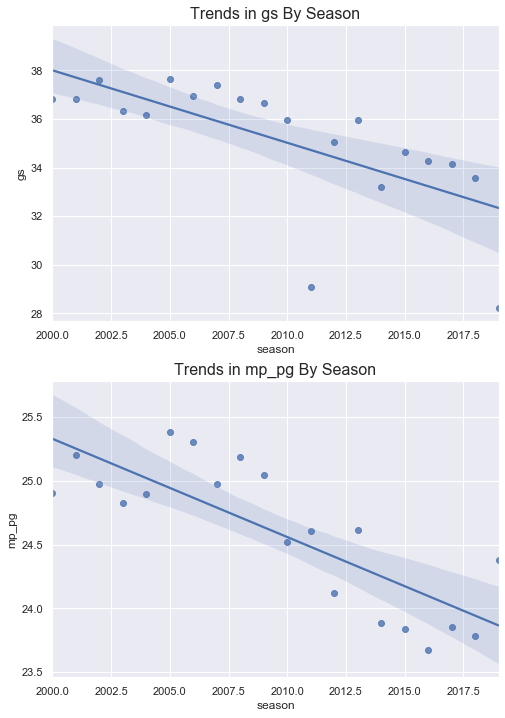

In [16]:
load_mgmt = ['gs', 'mp_pg']
labels = ['Games Started',
          'Minutes Per Game']

x=1
plt.figure(figsize=(8,12))
for col in load_mgmt:
    plt.subplot(210+x)
    plot_lin_trend(outlier_free_df, [col])
    x +=1
    
plt.show()

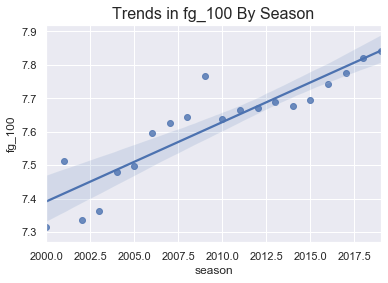

In [17]:
pace = ['fg_100']
plot_lin_trend(outlier_free_df, pace)

In [18]:
 rebs = ['orb_100', 'drb_100']

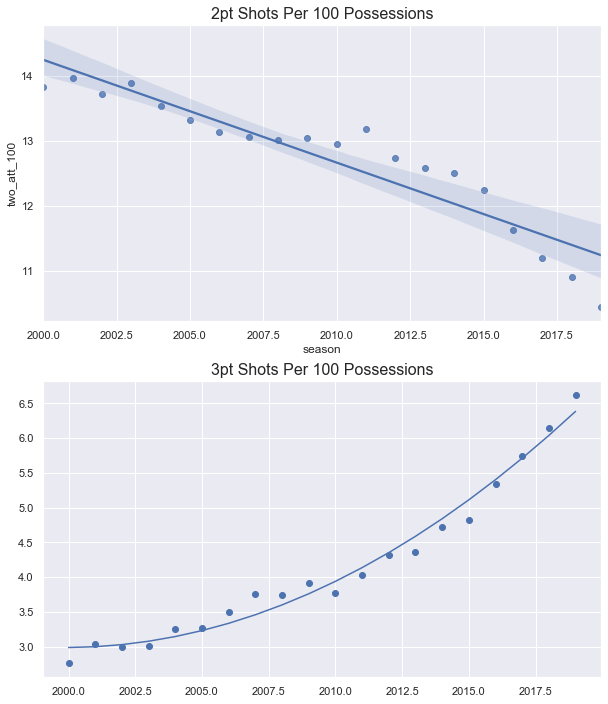

In [19]:
space = ['two_att_100', 'three_att_100']

fig = plt.figure(figsize=(10,12))
fig.tight_layout()


plt.subplot(211)
plot_lin_trend(outlier_free_df, ['two_att_100'])
plt.title("2pt Shots Per 100 Possessions", 
          fontdict={'fontsize':16})
plt.subplot(212)
plot_poly_trend(outlier_free_df, ['three_att_100'], 2)
plt.title("3pt Shots Per 100 Possessions",
          fontdict={'fontsize':16})
plt.show()

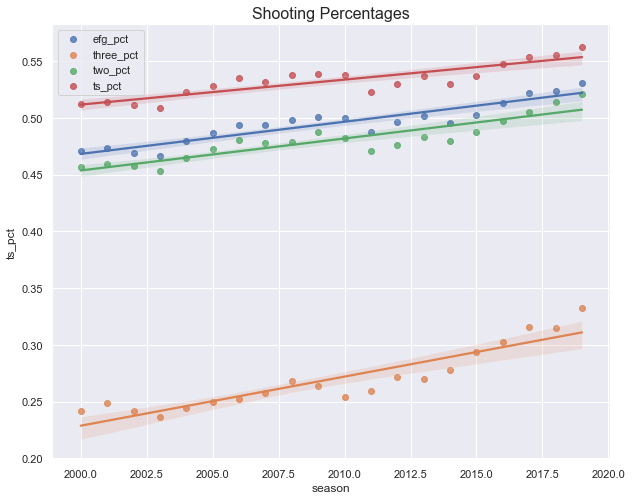

In [20]:
efficiency = ['efg_pct', 'three_pct', 'two_pct',
              #'tov_100', 
              'ts_pct']

fig = plt.figure(figsize=(10,8))
fig.tight_layout()
plot_lin_trend(outlier_free_df, efficiency)
plt.title('Shooting Percentages', 
          fontdict={'fontsize':16})
plt.legend()
plt.show()

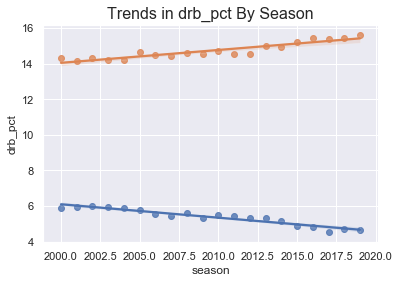

In [21]:
reb_pct = ['orb_pct', 'drb_pct']
for col in reb_pct:
    plot_lin_trend(outlier_free_df, [col])

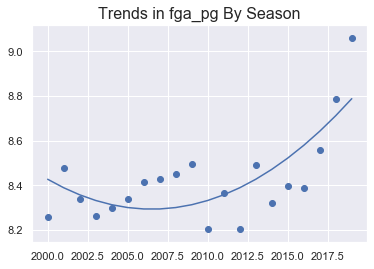

In [22]:
poly_pace = ['fga_pg']
plot_poly_trend(outlier_free_df, poly_pace, 2)

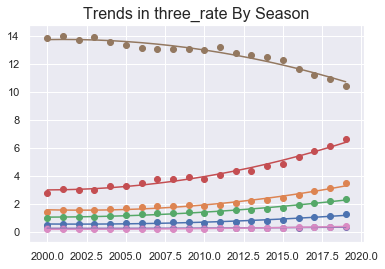

In [23]:
poly_space = ['three_pg', 'three_att_pg', 'three_100', 'three_att_100',
              'three_pct', 'two_att_100', 'three_rate'
             ]
plot_poly_trend(outlier_free_df, poly_space, 2)

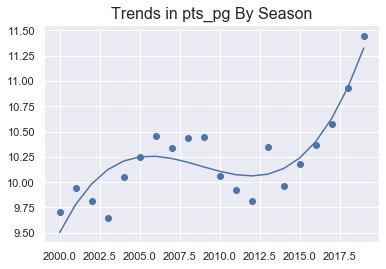

In [24]:
plot_poly_trend(outlier_free_df, ['pts_pg'], 3)

# Individual Player Over Time

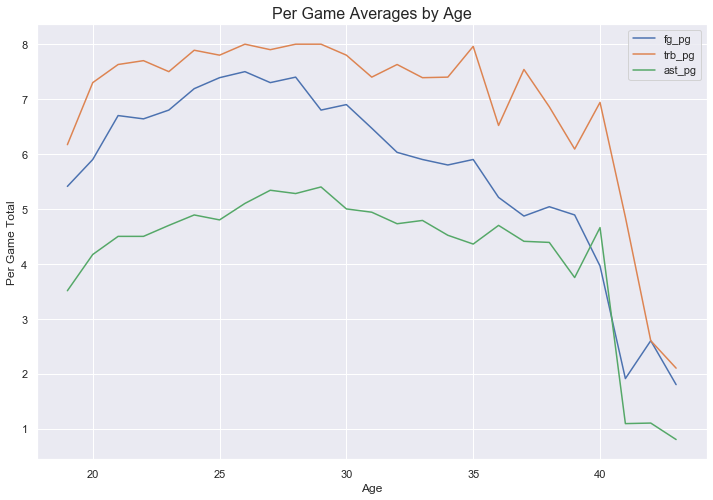

In [25]:
int_col = outlier_free_df.columns[outlier_free_df.dtypes != object]
age_df = outlier_free_df[int_col]


plt.figure(figsize=(12,8))
# plt.subplot(2,1,1)

hump = ['fg_pg', 'trb_pg', 'ast_pg']
for stat in hump:
    age_df.groupby('age').quantile(.90)[stat].plot()
plt.xlabel('Age')
plt.ylabel('Per Game Total')
plt.title('Per Game Averages by Age', fontdict={'fontsize':16})
plt.legend()

# plt.subplot(2,1,2)
# plt.title('Proportion of Allstars by Age', fontdict={'fontsize':16})
# age_df.groupby('age').mean()['allstar'].plot()
# plt.xlabel('Age')

plt.show()



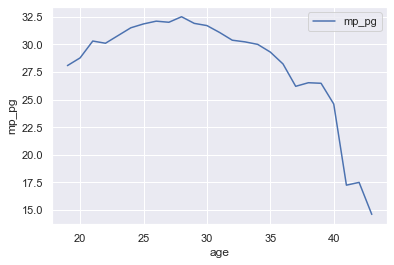

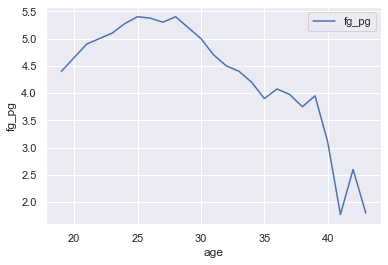

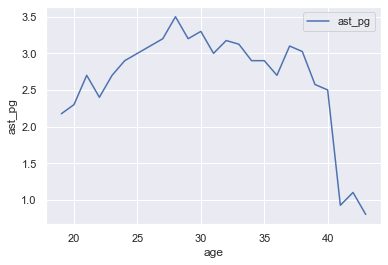

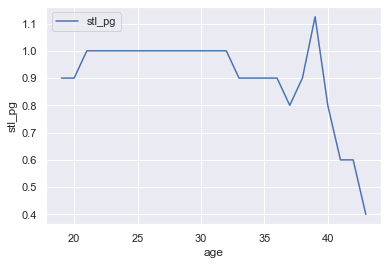

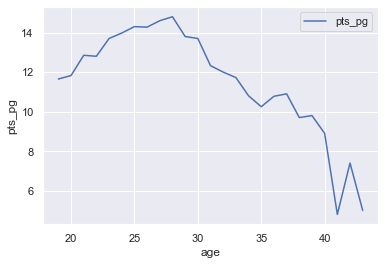

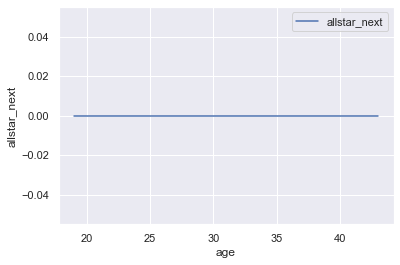

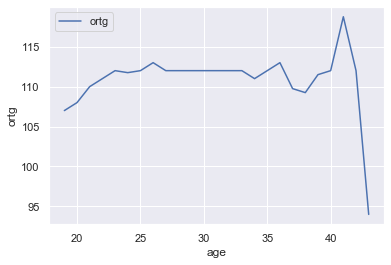

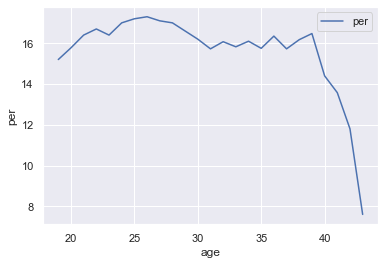

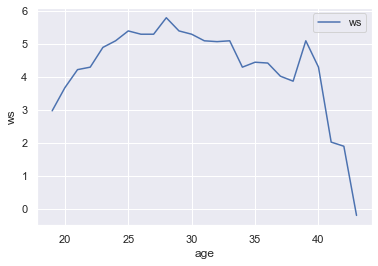

<Figure size 432x288 with 0 Axes>

In [26]:
hump = ['mp_pg', 'fg_pg', 'ast_pg', 
            'stl_pg', 'pts_pg', 'allstar_next',
            'ortg', 'per', 'ws'
           ]
for stat in hump:
    age_df.groupby('age').quantile(.75)[stat].plot()
    plt.ylabel(stat)
    plt.legend()
    plt.show()
    plt.clf()

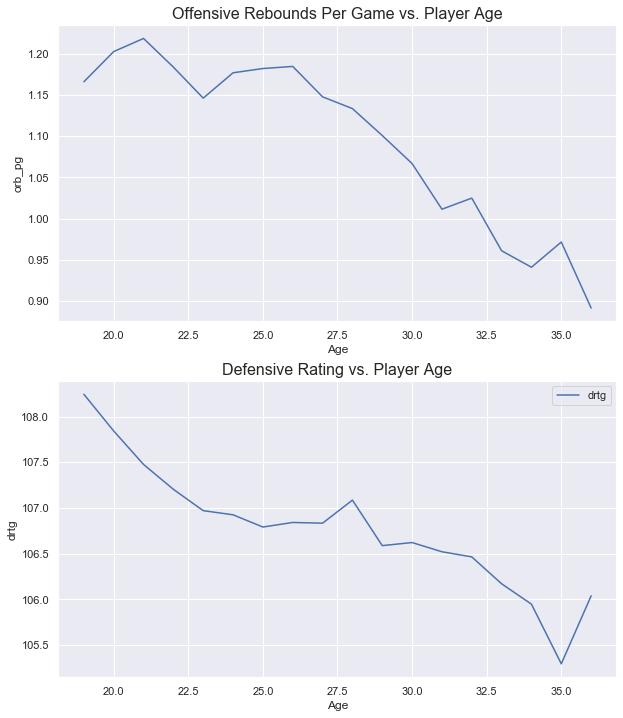

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(10, 12))
decline = ['orb_pg', 'drtg']
labels = ['Offensive Rebounds Per Game',
          'Defensive Rating'
         ]
x=1

for stat in decline:
    plt.subplot(210+x)
    age_df = outlier_free_df.groupby('age').mean()
    age_df[:36][stat].plot()
    plt.title('{} vs. Player Age'.format(labels[x-1]), 
              fontdict={'size':16}
             )
    plt.ylabel(stat)
    plt.xlabel('Age')
    x += 1
plt.legend()
plt.show()
plt.clf()

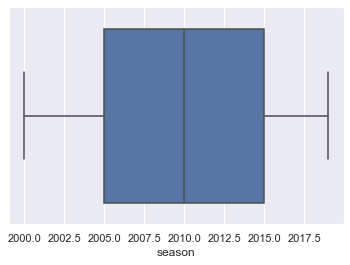

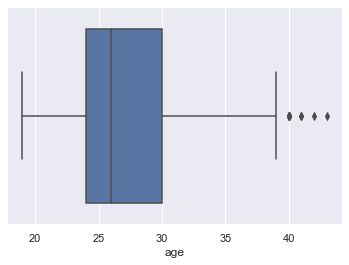

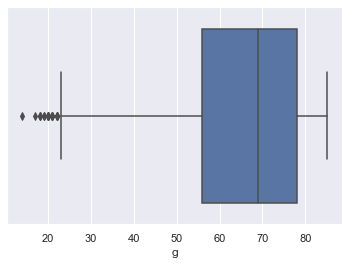

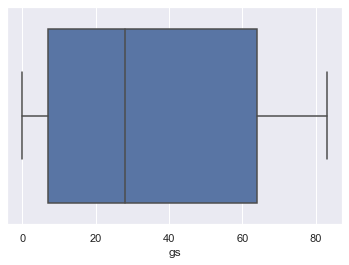

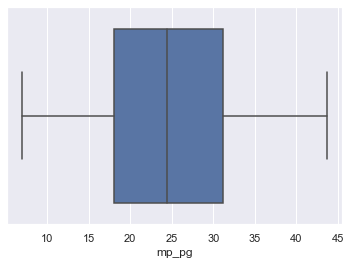

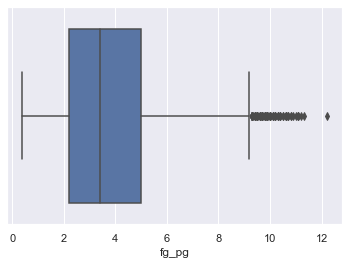

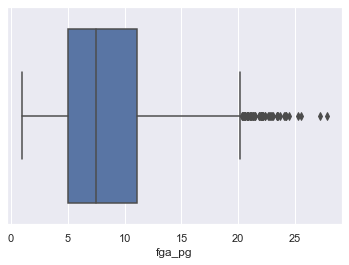

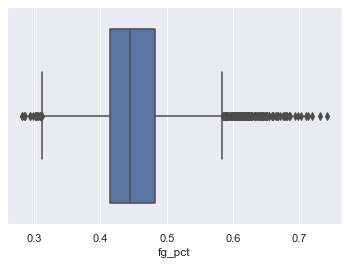

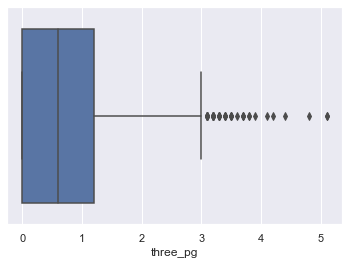

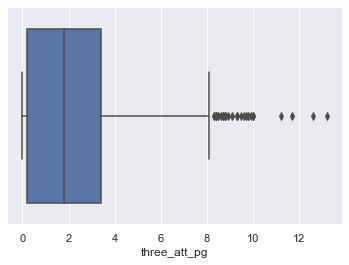

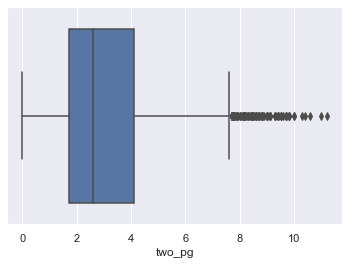

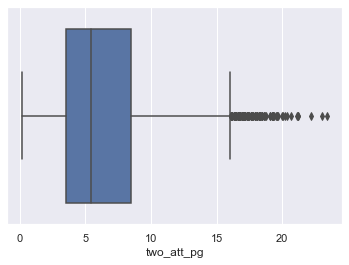

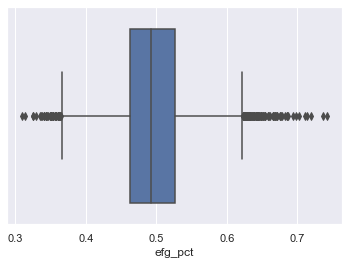

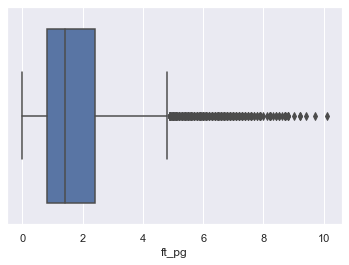

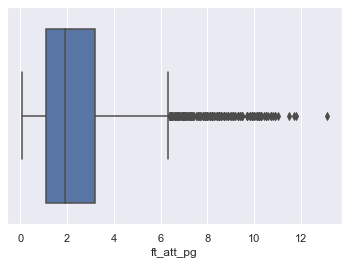

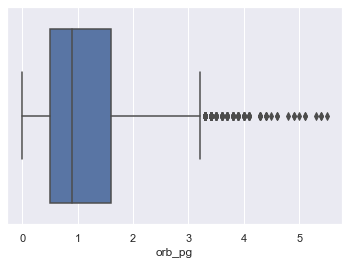

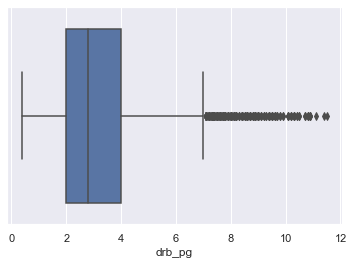

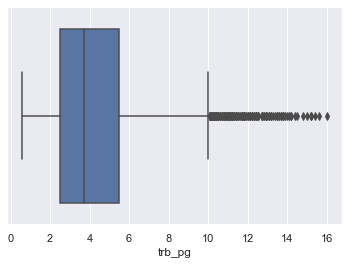

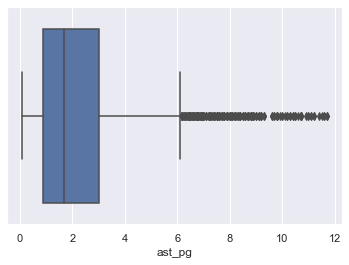

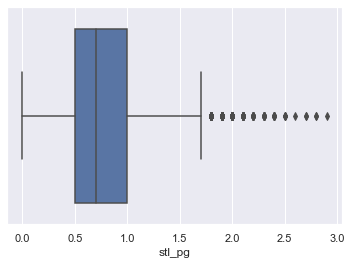

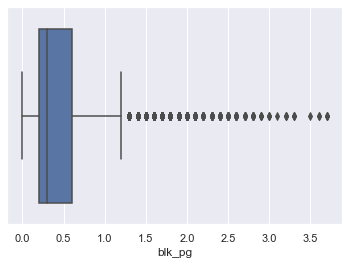

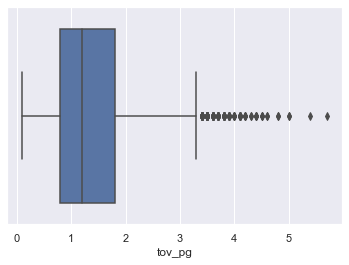

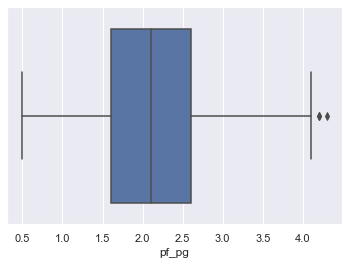

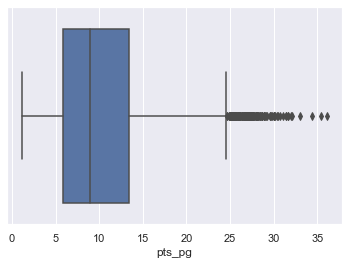

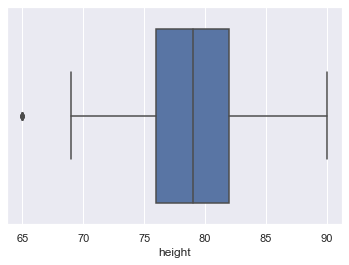

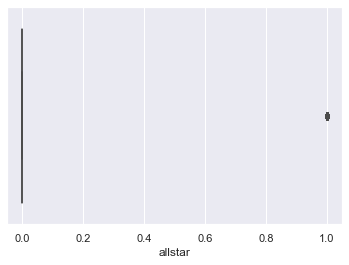

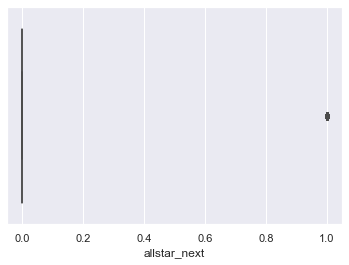

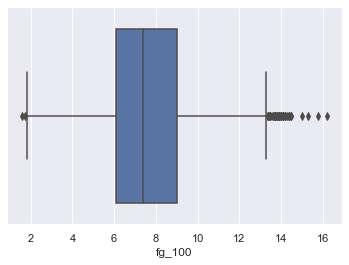

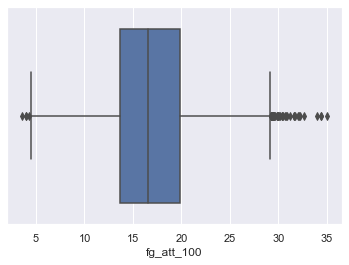

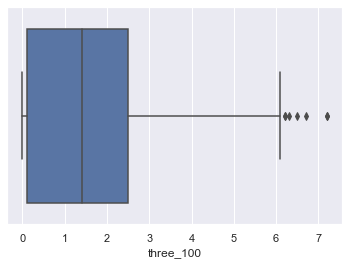

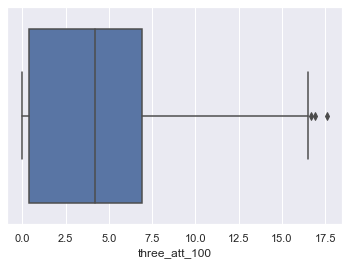

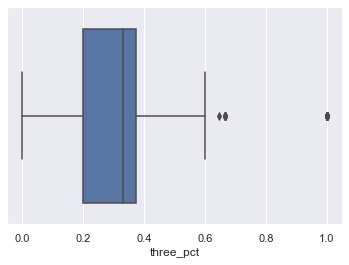

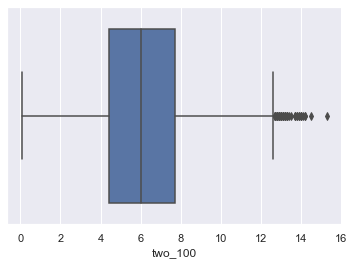

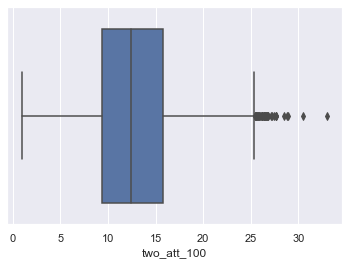

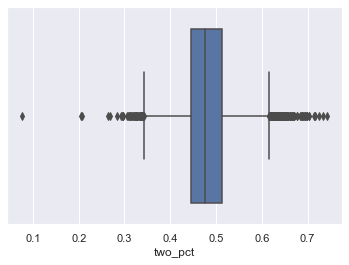

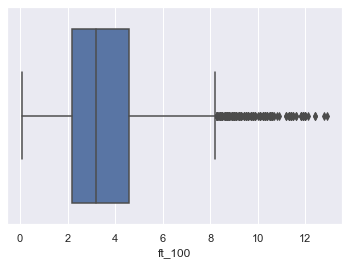

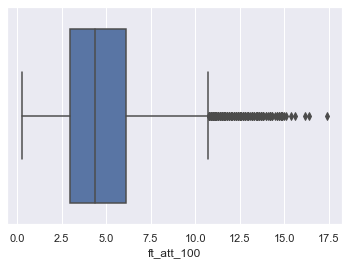

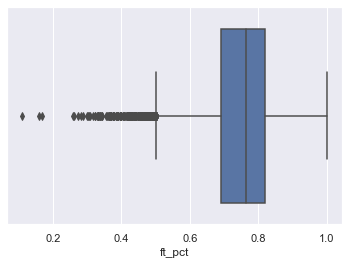

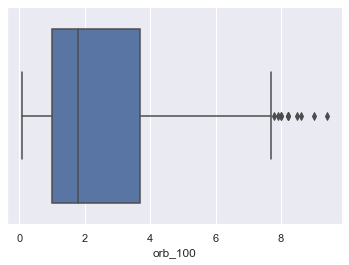

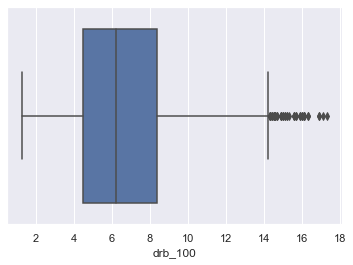

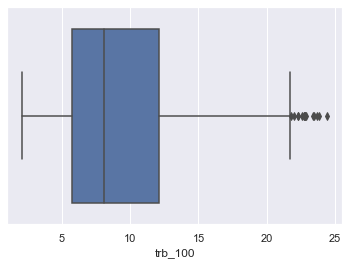

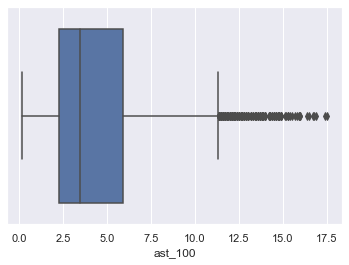

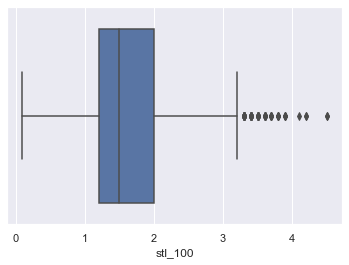

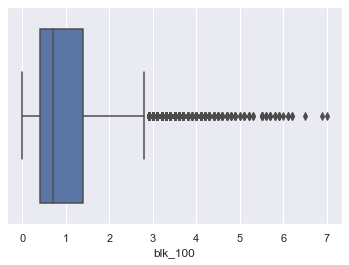

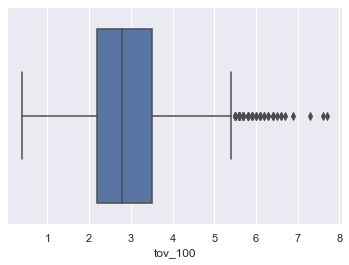

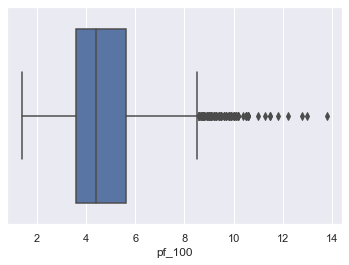

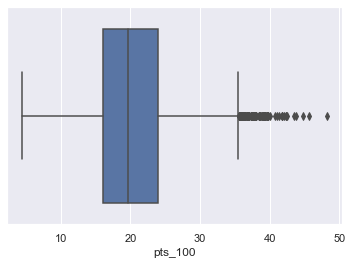

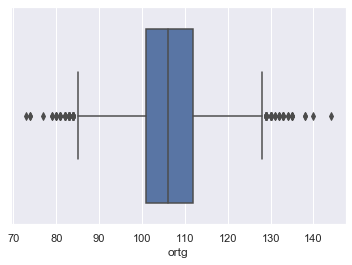

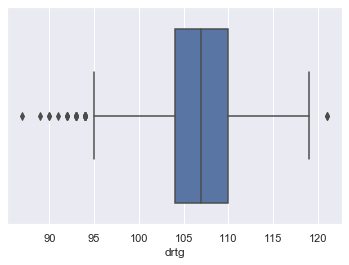

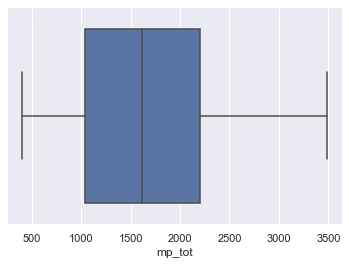

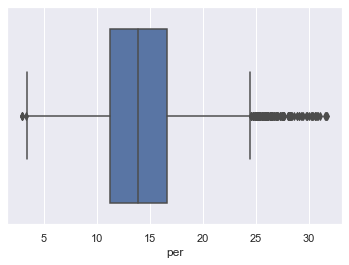

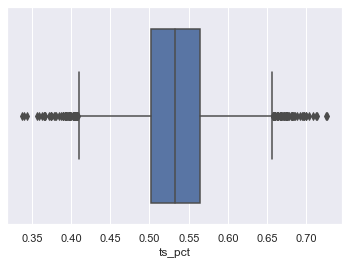

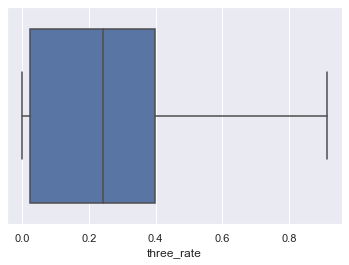

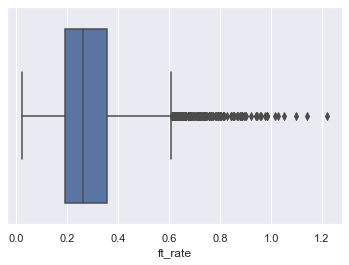

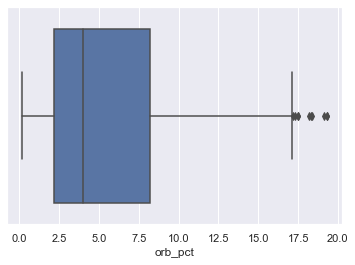

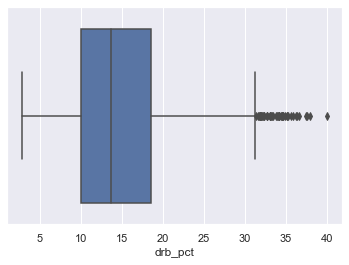

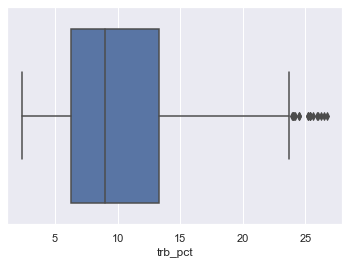

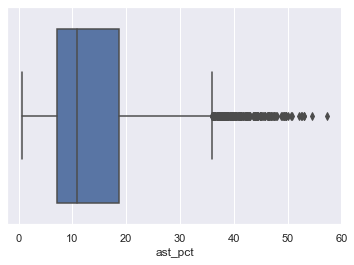

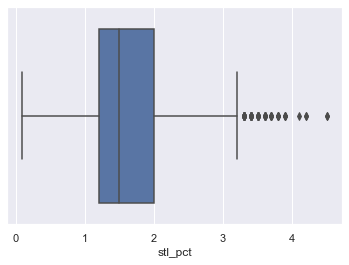

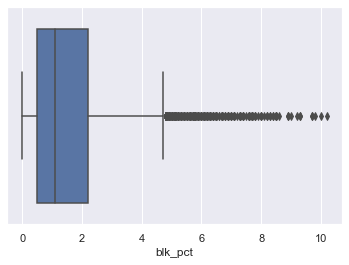

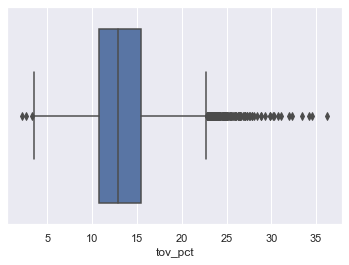

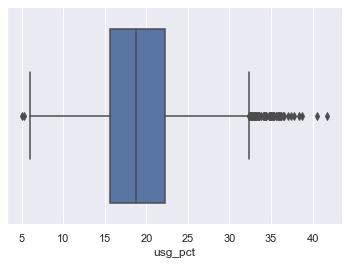

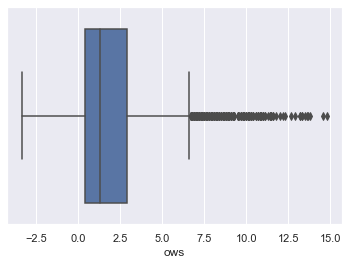

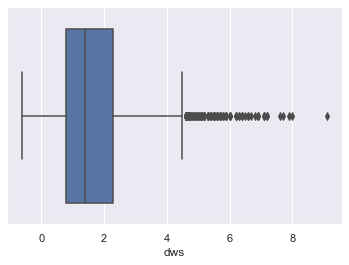

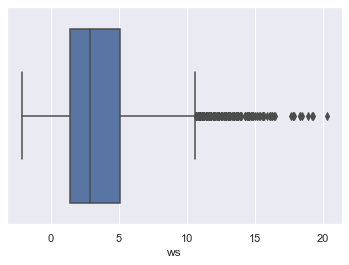

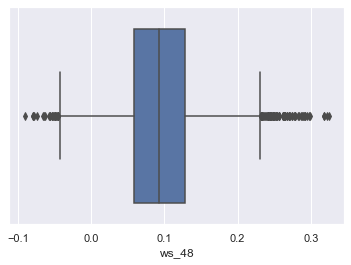

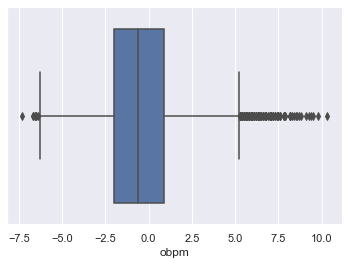

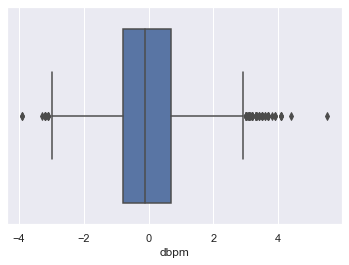

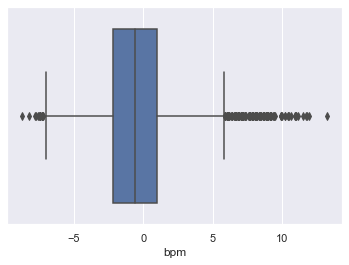

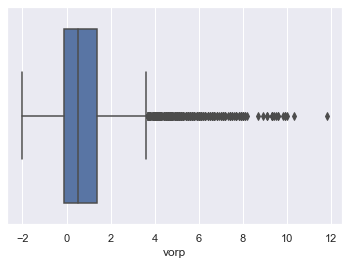

<Figure size 432x288 with 0 Axes>

In [28]:
for col in outlier_free_df:
    if outlier_free_df[col].dtype != object:
        sns.boxplot(x=outlier_free_df[col])
        plt.show()
        plt.title(col)
    plt.clf()

In [29]:
from scipy import stats
import numpy as np

z_df = outlier_free_df.select_dtypes(exclude=object).copy()
z = np.abs(stats.zscore(z_df))
z_outliers = np.where(z > 6)

In [30]:
x = list(zip(z_outliers[0], z_outliers[1]))

In [31]:
for i, j in x:
    print(i, outlier_free_df.iloc[i].player, outlier_free_df.columns[j])

777 Fabricio Oberto drb_pct
1150 LeBron James ws
1151 LeBron James ws
1154 LeBron James ws
1873 DeAndre Jordan drtg
3535 Chris Paul ws
3632 Serge Ibaka trb_pg
3821 Danny Fortson drtg
3988 Hassan Whiteside trb_pg
4068 Andris Biedriņš two_100
4194 Marcus Camby trb_pg
4569 Theo Ratliff trb_pg
4571 Theo Ratliff trb_pg
4747 Kevin Garnett ws
4897 Ben Wallace stl_pct
5368 Brian Cardinal three_100


In [32]:
outlier_free_df.columns

Index(['season', 'age', 'tm', 'lg', 'pos', 'g', 'gs', 'mp_pg', 'fg_pg',
       'fga_pg', 'fg_pct', 'three_pg', 'three_att_pg', 'two_pg', 'two_att_pg',
       'efg_pct', 'ft_pg', 'ft_att_pg', 'orb_pg', 'drb_pg', 'trb_pg', 'ast_pg',
       'stl_pg', 'blk_pg', 'tov_pg', 'pf_pg', 'pts_pg', 'height', 'href',
       'player', 'allstar', 'allstar_next', 'fg_100', 'fg_att_100',
       'three_100', 'three_att_100', 'three_pct', 'two_100', 'two_att_100',
       'two_pct', 'ft_100', 'ft_att_100', 'ft_pct', 'orb_100', 'drb_100',
       'trb_100', 'ast_100', 'stl_100', 'blk_100', 'tov_100', 'pf_100',
       'pts_100', 'ortg', 'drtg', 'mp_tot', 'per', 'ts_pct', 'three_rate',
       'ft_rate', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct',
       'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_48', 'obpm',
       'dbpm', 'bpm', 'vorp'],
      dtype='object')

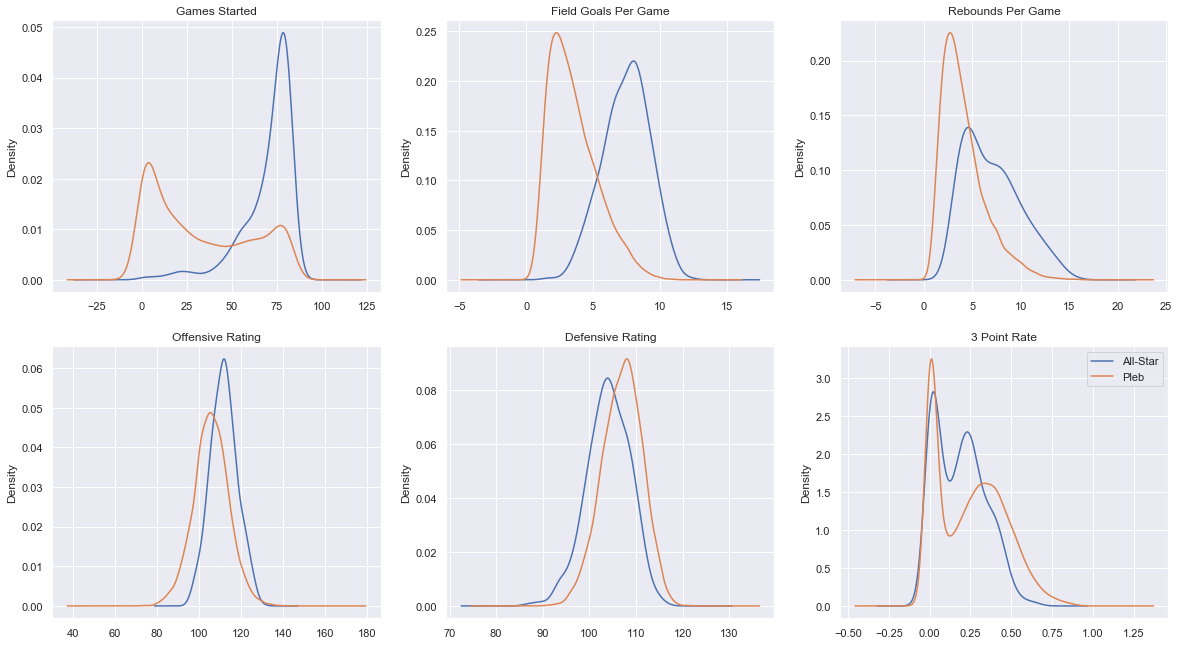

In [33]:
labels = {'gs':'Games Started',
          'fg_pg':'Field Goals Per Game', 
          'trb_pg':'Rebounds Per Game',
          'ortg':'Offensive Rating', 
          'drtg':'Defensive Rating', 
          'three_rate':'3 Point Rate'}
x=1
plt.figure(figsize=(20, 11))
for col, name in labels.items():
    if (outlier_free_df[col].dtype!=object) & (col!='season') & (col!='allstar_next'):
        plt.subplot(2, 3, x)
        outlier_free_df[outlier_free_df.allstar_next==1][col].plot(kind='kde', label='All-Star')
        outlier_free_df[outlier_free_df.allstar_next==0][col].plot(kind='kde', label='Pleb')
        plt.title(name) 
        x += 1
plt.legend()
plt.show()

# Data Normalization
This really screws up everything so not implementing

In [34]:
# from sklearn.preprocessing import StandardScaler

# int_df = outlier_free_df.loc[:, 
#                 [col for col in df if (df[col].dtype != object) 
#                                     & (col not in ('season', 
#                                                    'allstar', 
#                                                    'allstar_next')
#                                       )
#                 ]
#                ]

# x = int_df.values #returns a numpy array
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
# scaled_df = pd.DataFrame(x_scaled)
# scaled_df['allstar'] = df['allstar']
# scaled_df['allstar_next'] = df['allstar_next']

# scaled_df_cols =[col for col in outlier_free_df if col not in ('season','tm', 'lg', 'pos', 
#                                                   'href', 'player',
#                                                   'allstar', 'allstar_next')]\
#                 + ['allstar', 'allstar_next']

# scaled_df.columns = scaled_df_cols

# scaled_df.insert(0, 'season', outlier_free_df['season'])

# Intraseason Rankings?

Something to consider is that allstars are (theoretically) selected based on performance in a single season. Therefore, it may be worthwhile to scale every stat in relation to the maximum and minimum performance that season.

In [35]:
rank_df = pd.DataFrame()
for season in outlier_free_df.season.unique():
    
    if rank_df.shape[0] > 0:
        season_df = outlier_free_df[outlier_free_df.season == season].copy()
        rank_df = rank_df.append(season_df.rank(axis=0))
    else:
        rank_df = outlier_free_df[outlier_free_df.season == season].copy().rank(axis=0)
        


rank_df.columns = [col+'_rank' for col in outlier_free_df]

In [36]:
rank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6693 entries, 0 to 6692
Data columns (total 75 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season_rank         6693 non-null   float64
 1   age_rank            6693 non-null   float64
 2   tm_rank             6693 non-null   float64
 3   lg_rank             6693 non-null   float64
 4   pos_rank            6693 non-null   float64
 5   g_rank              6693 non-null   float64
 6   gs_rank             6693 non-null   float64
 7   mp_pg_rank          6693 non-null   float64
 8   fg_pg_rank          6693 non-null   float64
 9   fga_pg_rank         6693 non-null   float64
 10  fg_pct_rank         6693 non-null   float64
 11  three_pg_rank       6693 non-null   float64
 12  three_att_pg_rank   6693 non-null   float64
 13  two_pg_rank         6693 non-null   float64
 14  two_att_pg_rank     6693 non-null   float64
 15  efg_pct_rank        6693 non-null   float64
 16  ft_pg_

In [37]:
rank_df.head()
rank_df.drop(columns=['season_rank', 'tm_rank', 'lg_rank',
                      'pos_rank', 'href_rank', 'player_rank',
                      'allstar_rank', 'allstar_next_rank'
                     ], inplace=True)

# Significant Differences?

I want to see if there are big differences between all star seasons and non-all star seasons.

- The null hypothesis is that there is no significant difference between the mean values for all star seasons and non all star seasons.
- The alternate hypothesis is that there is a significant difference between the means of both.

My original $\alpha$ value is 0.05, but since I am testing 70 columns simultaneously, I need to perform a Bonferroni correction on my $\alpha$ by dividing 0.05 by 29. After doing so, my new $\alpha$ = 0.0007.

In [38]:
outlier_free_df.sort_index(inplace=True)

In [39]:
rank_df.sort_index(inplace=True)

In [40]:
full_df = pd.merge(outlier_free_df, rank_df, on=rank_df.index)
full_df.drop(columns=['key_0'], inplace=True)

In [41]:
eda_df = full_df.select_dtypes(exclude=object)
allstar = eda_df[eda_df.allstar_next == 1]
nostar = eda_df[eda_df.allstar_next == 0]

In [42]:
h_o = zip(allstar.columns, weightstats.ztest(nostar, allstar)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
print('Column: p-value')
for i in list(h_o):
    print(i[0], ':', 
          sig(i[1], 0.05/70))

Column: p-value
season : Significant
age : Not significant
g : Significant
gs : Significant
mp_pg : Significant
fg_pg : Significant
fga_pg : Significant
fg_pct : Significant
three_pg : Significant
three_att_pg : Significant
two_pg : Significant
two_att_pg : Significant
efg_pct : Significant
ft_pg : Significant
ft_att_pg : Significant
orb_pg : Significant
drb_pg : Significant
trb_pg : Significant
ast_pg : Significant
stl_pg : Significant
blk_pg : Significant
tov_pg : Significant
pf_pg : Significant
pts_pg : Significant
height : Not significant
allstar : Significant
allstar_next : Significant
fg_100 : Significant
fg_att_100 : Significant
three_100 : Not significant
three_att_100 : Not significant
three_pct : Significant
two_100 : Significant
two_att_100 : Significant
two_pct : Significant
ft_100 : Significant
ft_att_100 : Significant
ft_pct : Significant
orb_100 : Not significant
drb_100 : Significant
trb_100 : Significant
ast_100 : Significant
stl_100 : Significant
blk_100 : Significant

/Users/drewadamski/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff


In nearly every single category, there is a significant difference between allstars and non allstars. The only columns that are not significantly different are `season`, `age`, `height`, `orb_100`, and `orb_pct`.

However, just because a difference is statistically significant, it is not necessarily functionally significant.

In [43]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


In [44]:
h_o = zip(allstar.columns, weightstats.ztest(nostar, allstar)[1])

cohen_dict = defaultdict(str)
for i in list(h_o):
    if sig(i[1], 0.05/70) == 'Significant':
        cohen = cohend(allstar[i[0]], nostar[i[0]])
        
        if cohen <= 0.2:
            effect = 'Small'
        elif cohen <= 0.5:
            effect = 'Medium'
        else:
            effect = 'Large'
            
        cohen_dict[i[0]] = effect


/Users/drewadamski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


In [45]:
cohen_series = pd.Series(cohen_dict, 
                        index=[key for key, value in cohen_dict.items()])

In [46]:
cohen_series[cohen_series=='Large']

gs            Large
mp_pg         Large
fg_pg         Large
fga_pg        Large
three_pg      Large
              ...  
ws_rank       Large
ws_48_rank    Large
obpm_rank     Large
bpm_rank      Large
vorp_rank     Large
Length: 90, dtype: object

In [47]:
cnt = Counter()
for key, value in cohen_dict.items():
    cnt[value] += 1
cnt

Counter({'Small': 9, 'Medium': 25, 'Large': 90})

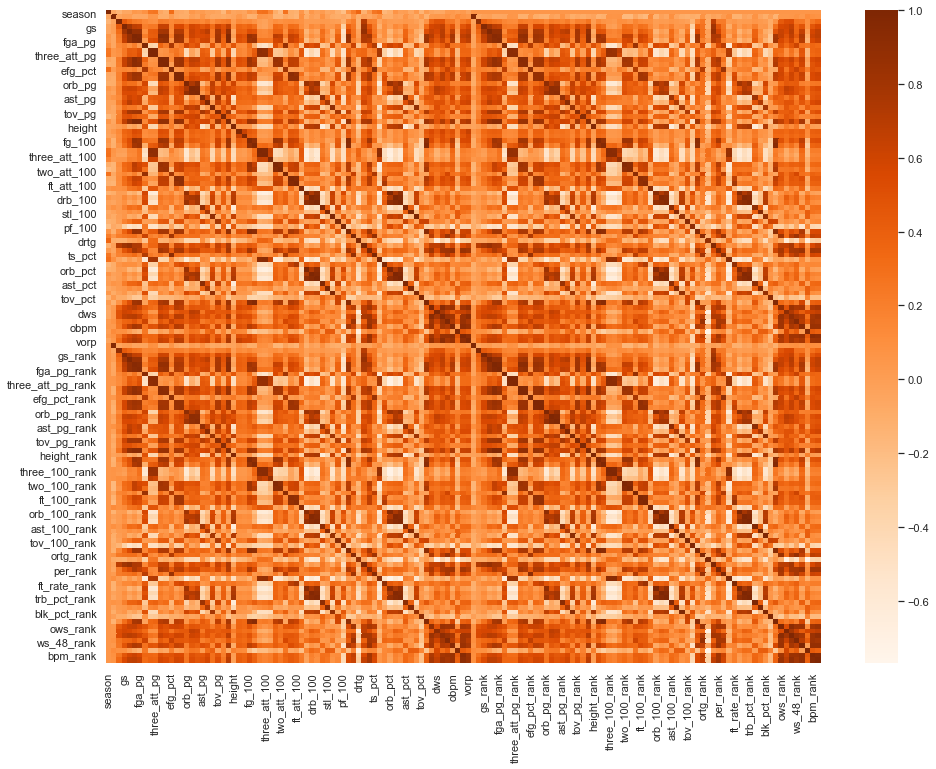

In [48]:
_ = plt.figure(figsize=(16,12))
_ = sns.heatmap(full_df.corr(), cmap='Oranges')

In [49]:
def compare_correlations(corr_df, col1, col2, target):
    '''Given a correlation dataframe and two separate 
       dataframe columns, determine which column has
       a lower absolute correlation to the target 
       variable and return it.'''
    
    cord = {abs(corr_df.loc[target, col1]):col1,
            abs(corr_df.loc[target, col2]):col2
           }
    
    return cord[min(cord)]


def find_col(corr_df, col1, threshold=0.8):
    '''identifies colinear columns and
       returns Series of column names and
       correlation coefficients.'''
    
    colinear = corr_df.loc[col1, abs(corr_df[col1]) > threshold]
    colinear.drop(col1, axis=0, inplace=True)
    return colinear


def remove_colinear(df, target, threshold=0.8):
    '''Given a dataframe, remove colinear features
       based on which is more highly correlated with
       the target variable. Optional threshold variable
       sets correlation coefficient value at which
       a feature is dropped.'''
    
    drop_set = set()
    # Create correlation dataframe
    corr_df = df.corr()
    
    # identify colinear columns
    for col in corr_df:
        colinear_series = find_col(corr_df, col, threshold)
        if len(colinear_series) > 1:
            for subcol in colinear_series.index:
            # add least correlated column to drop_set
                drop_set.add(compare_correlations(corr_df, col, subcol, target))
    # drop colinear variable with lower
    # correlation to target
    return list(drop_set)

In [50]:
full_df

,season,age,tm,lg,pos,g,gs,mp_pg,fg_pg,fga_pg,...,tov_pct_rank,usg_pct_rank,ows_rank,dws_rank,ws_rank,ws_48_rank,obpm_rank,dbpm_rank,bpm_rank,vorp_rank
0,2000,24.0,LAC,NBA,PF,39.0,23.0,15.0,1.6,4.1,...,190.0,125.0,34.0,55.0,29.0,37.0,39.5,61.5,33.5,62.5
1,2001,25.0,CLE,NBA,PF,65.0,8.0,17.0,1.4,2.5,...,276.5,6.0,130.5,105.5,107.5,129.5,73.0,153.5,78.0,81.5
2,2002,26.0,PHI,NBA,PF,77.0,9.0,17.9,2.4,4.3,...,148.0,77.5,193.5,202.0,197.0,264.5,157.0,172.5,161.5,154.0
3,2003,27.0,MIL,NBA,C,56.0,54.0,28.2,4.6,9.2,...,93.0,173.5,153.0,188.5,155.5,131.5,141.5,94.5,110.0,118.5
4,2004,28.0,TOT,NBA,PF-C,49.0,23.0,19.2,2.1,4.2,...,213.0,30.5,112.5,145.5,115.5,174.5,113.5,220.0,141.0,131.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,2019,23.0,BOS,NBA,SF,50.0,50.0,34.0,7.6,15.4,...,141.0,265.5,220.5,271.5,255.0,228.5,230.5,152.0,218.0,230.0
6689,2019,31.0,CLE,NBA,PF,56.0,56.0,31.8,5.8,13.0,...,239.5,244.0,247.0,160.0,223.0,170.5,283.0,100.5,261.0,274.5
6690,2019,29.0,DEN,NBA,SF,58.0,58.0,33.0,5.7,12.7,...,81.5,201.5,240.0,259.0,255.0,196.0,242.5,152.0,229.0,256.5
6691,2019,28.0,MIL,NBA,SF,55.0,52.0,30.1,7.7,15.5,...,107.0,278.0,295.5,301.5,301.0,299.5,294.0,235.5,301.0,297.0


In [51]:
droppable = remove_colinear(full_df, 'allstar_next', threshold=.8)

dropped_df = full_df.drop(droppable, axis=1)

dropped_df.shape

(6693, 42)

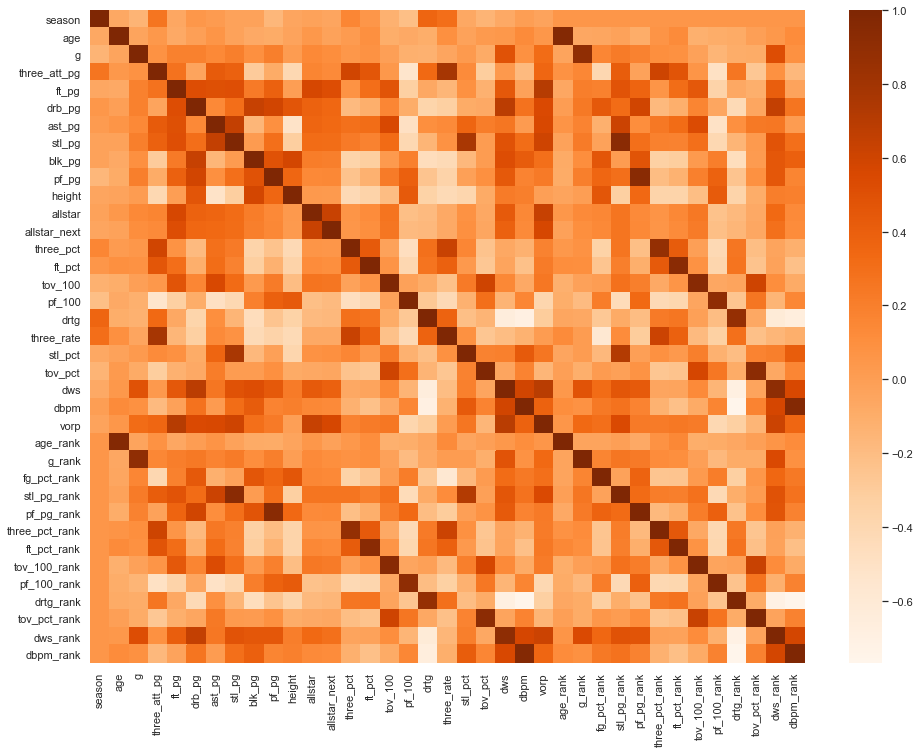

In [52]:
_ = plt.figure(figsize=(16,12))
_ = sns.heatmap(dropped_df.corr(), cmap='Oranges')

In [53]:
dropped_df.to_csv(sys.path[-1]+'/model_data.csv')